this kernel was forked from here : https://www.kaggle.com/samusram/cloud-classifier-for-post-processing?scriptVersionId=20265194

highest  accuracy of that kernel was 0.629 which is same as this one : https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools?scriptVersionId=20202006 of Andrew Lukyanenko (  @artgor) 
thanks a lot to them for their public kernels,i recommend everyone playing with those kernels because those kernels has got solid baseline. my special thanks goes to Andrew Lukyanenko (  @artgor) ,i learnt plenty from his works 

Here in this kernel i got 0.63 after trying InceptionResNetV2 so i decided to share it with you guys,please leave your precious comment below,this is just a starting,i will write my own notebook when time permits but i would like to spend more time on @artgor's kernel to observe if i can improve his work little bit,i recommend you the same.

whats new here?
1. InceptionResNetV2 instead of densenet121
2. image height and width 229x229 instead of 224
3. version 1 has got 0.63 public lb accuracy ,so please upvote this notebok and obviously main author's notebook if you find these helpful
4.  in version 3 i will try to leave everything as it was before but 5 epochs for initial tuning and 10 epochs for fine tuning

**Version 6**
- replacing this notebook's submission.csv with my trained models submission.csv file(got 0.658 public lb score) which comes from version 13 of this notebook : https://www.kaggle.com/mobassir/keras-efficientnetb2-for-classifying-cloud

- using 0.90 as both precision and recall threshold
- Rotate(limit=20)


# version 7
- using 0.94 as both precision and recall threshold
- 17% for test set
- lower learning rate
- train for less epoches

<font color="red">i hope this kernel is helpful and some upvotes are highly appreciated!</font>

# Intro
In this notebook I'd create a classifier to distinguish types of cloud formations. Using this classifier I'd check if it improves currently the best LB score from the great [public notebook by Andrew](https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools?scriptVersionId=20202006). 

# Plan
1. [Libraries](#Libraries)
2. [Data Generators](#Data-Generators)
  * [One-hot encoding classes](#One-hot-encoding-classes)
  * [Stratified split into train/val](#Stratified-split-into-train/val)
  * [Generator class](#Generator-class)
3. [PR-AUC-based Callback](#PR-AUC-based-Callback)
4. [Classifier](#Classifier)
  * [Defining a model](#Defining-a-model)
  * [Initial tuning of the added fully-connected layer](#Initial-tuning-of-the-added-fully-connected-layer)
  * [Fine-tuning the whole model](#Fine-tuning-the-whole-model)
  * [Visualizing train and val PR AUC](#Visualizing-train-and-val-PR-AUC)
5. [Selecting postprocessing thresholds](#Selecting-postprocessing-thresholds)
6. [Post-processing Andrew's submission](#Post-processing-Andrew's-submission)
7. [Future work](#Future-work)

# Libraries

In [1]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion,CenterCrop
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
from tensorflow import set_random_seed
set_random_seed(10)
%matplotlib inline

In [3]:
test_imgs_folder = './input/test_images/'
train_imgs_folder = './input/train_images/'
num_cores = multiprocessing.cpu_count()

# Data Generators

## One-hot encoding classes

In [4]:
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [5]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Sugar, Fish, Flower}",1,1,1,0
2,0031ae9.jpg,"{Sugar, Fish, Flower}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Sugar, Fish, Gravel}",1,0,1,1


In [6]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

## Stratified split into train/val

In [7]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.12, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=13)

## Generator class

In [8]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, 
                 batch_size=16, shuffle=True, augmentation=None,
                 resized_height=299, resized_width=299, num_channels=3):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_height, self.resized_width)).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [9]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [10]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False)
data_generator_val = DataGenenerator(val_imgs, shuffle=False)

# PR-AUC-based Callback

The callback would be used:
1. to estimate AUC under precision recall curve for each class,
2. to early stop after 5 epochs of no improvement in mean PR AUC,
3. save a model with the best PR AUC in validation,
4. to reduce learning rate on PR AUC plateau.

In [11]:
class PrAucCallback(Callback):
    def __init__(self, data_generator, num_workers=num_cores, 
                 early_stopping_patience=3, 
                 plateau_patience=3, reduction_rate=0.5,
                 stage='train', checkpoints_path='checkpoints/'):
        super(Callback, self).__init__()
        self.data_generator = data_generator
        self.num_workers = num_workers
        self.class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
        self.history = [[] for _ in range(len(self.class_names) + 1)] # to store per each class and also mean PR AUC
        self.early_stopping_patience = early_stopping_patience
        self.plateau_patience = plateau_patience
        self.reduction_rate = reduction_rate
        self.stage = stage
        self.best_pr_auc = -float('inf')
        if not os.path.exists(checkpoints_path):
            os.makedirs(checkpoints_path)
        self.checkpoints_path = checkpoints_path
        
    def compute_pr_auc(self, y_true, y_pred):
        pr_auc_mean = 0
        print(f"\n{'#'*30}\n")
        for class_i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/len(self.class_names)
            print(f"PR AUC {self.class_names[class_i]}, {self.stage}: {pr_auc:.3f}\n")
            self.history[class_i].append(pr_auc)        
        print(f"\n{'#'*20}\n PR AUC mean, {self.stage}: {pr_auc_mean:.3f}\n{'#'*20}\n")
        self.history[-1].append(pr_auc_mean)
        return pr_auc_mean
              
    def is_patience_lost(self, patience):
        if len(self.history[-1]) > patience:
            best_performance = max(self.history[-1][-(patience + 1):-1])
            return best_performance == self.history[-1][-(patience + 1)] and best_performance >= self.history[-1][-1]    
              
    def early_stopping_check(self, pr_auc_mean):
        if self.is_patience_lost(self.early_stopping_patience):
            self.model.stop_training = True    
              
    def model_checkpoint(self, pr_auc_mean, epoch):
        if pr_auc_mean > self.best_pr_auc:
            # remove previous checkpoints to save space
            for checkpoint in glob.glob(os.path.join(self.checkpoints_path, 'classifier_epoch_*')):
                os.remove(checkpoint)
        self.best_pr_auc = pr_auc_mean
        self.model.save(os.path.join(self.checkpoints_path, f'classifier_epoch_{epoch}_val_pr_auc_{pr_auc_mean}.h5'))              
        print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
              
    def reduce_lr_on_plateau(self):
        if self.is_patience_lost(self.plateau_patience):
            new_lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.reduction_rate
            keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n{'#'*20}\nReduced learning rate to {new_lr}.\n{'#'*20}\n")
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_generator(self.data_generator, workers=self.num_workers)
        y_true = self.data_generator.get_labels()
        # estimate AUC under precision recall curve for each class
        pr_auc_mean = self.compute_pr_auc(y_true, y_pred)
              
        if self.stage == 'val':
            # early stop after early_stopping_patience=4 epochs of no improvement in mean PR AUC
            self.early_stopping_check(pr_auc_mean)

            # save a model with the best PR AUC in validation
            self.model_checkpoint(pr_auc_mean, epoch)

            # reduce learning rate on PR AUC plateau
            self.reduce_lr_on_plateau()            
        
    def get_pr_auc_history(self):
        return self.history

Callback instances

In [16]:
train_metric_callback = PrAucCallback(data_generator_train_eval, early_stopping_patience=7, plateau_patience=2, reduction_rate=0.3,)
val_callback = PrAucCallback(data_generator_val, stage='val')

# Classifier

## Defining a model

> Let's us InceptionResNetV2 pretrained on ImageNet.

In [13]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
def get_model():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

Instructions for updating:
Colocations handled automatically by placer.


> ## Initial tuning of the added fully-connected layer

In [21]:
for base_layer in model.layers[:-1]:
    base_layer.trainable = False
    
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy')
history_0 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


KeyboardInterrupt: 

## Fine-tuning the whole model

After unfreezing all the layers I set a less aggressive initial learning rate and train until early stopping (or 100 epochs max).

In [55]:
for base_layer in model.layers[:-1]:
    base_layer.trainable = True
    
model.compile(optimizer=Adam(lr=0.00025), loss='binary_crossentropy')
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=13,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/13


12/41 [=======>......................].] - ETA: 11:07:38 - loss: 0.433 - ETA: 5:34:43 - loss: 0.426 - ETA: 3:43:45 - loss: 0.43 - ETA: 2:48:15 - loss: 0.43 - ETA: 2:14:56 - loss: 0.45 - ETA: 1:52:44 - loss: 0.44 - ETA: 1:36:51 - loss: 0.43 - ETA: 1:24:57 - loss: 0.44 - ETA: 1:15:42 - loss: 0.44 - ETA: 1:08:17 - loss: 0.44 - ETA: 1:02:13 - loss: 0.44 - ETA: 57:11 - loss: 0.4379 - ETA: 52:55 - loss: 0.44 - ETA: 49:14 - loss: 0.44 - ETA: 46:04 - loss: 0.46 - ETA: 43:17 - loss: 0.45 - ETA: 40:49 - loss: 0.45 - ETA: 38:38 - loss: 0.45 - ETA: 36:40 - loss: 0.45 - ETA: 34:54 - loss: 0.45 - ETA: 33:18 - loss: 0.45 - ETA: 31:50 - loss: 0.45 - ETA: 30:31 - loss: 0.45 - ETA: 29:17 - loss: 0.45 - ETA: 28:10 - loss: 0.45 - ETA: 27:08 - loss: 0.44 - ETA: 26:10 - loss: 0.44 - ETA: 25:16 - loss: 0.44 - ETA: 24:26 - loss: 0.44 - ETA: 23:40 - loss: 0.44 - ETA: 22:56 - loss: 0.44 - ETA: 22:15 - loss: 0.44 - ETA: 21:36 - loss: 0.44 - ETA: 21:00 - loss: 0.45 - ETA: 20:25 - loss: 0.44 - ETA: 19:53 - loss: 0

17/41 [===========>..................].] - ETA: 4:03 - loss: 0.456 - ETA: 4:00 - loss: 0.399 - ETA: 3:58 - loss: 0.415 - ETA: 3:56 - loss: 0.411 - ETA: 3:55 - loss: 0.433 - ETA: 3:54 - loss: 0.448 - ETA: 3:54 - loss: 0.459 - ETA: 3:53 - loss: 0.460 - ETA: 3:53 - loss: 0.448 - ETA: 3:52 - loss: 0.449 - ETA: 3:51 - loss: 0.451 - ETA: 3:50 - loss: 0.441 - ETA: 3:49 - loss: 0.444 - ETA: 3:48 - loss: 0.438 - ETA: 3:47 - loss: 0.445 - ETA: 3:47 - loss: 0.445 - ETA: 3:46 - loss: 0.442 - ETA: 3:45 - loss: 0.439 - ETA: 3:45 - loss: 0.445 - ETA: 3:44 - loss: 0.445 - ETA: 3:43 - loss: 0.446 - ETA: 3:42 - loss: 0.450 - ETA: 3:42 - loss: 0.447 - ETA: 3:41 - loss: 0.445 - ETA: 3:40 - loss: 0.439 - ETA: 3:39 - loss: 0.441 - ETA: 3:38 - loss: 0.443 - ETA: 3:38 - loss: 0.442 - ETA: 3:37 - loss: 0.445 - ETA: 3:36 - loss: 0.450 - ETA: 3:35 - loss: 0.449 - ETA: 3:34 - loss: 0.447 - ETA: 3:33 - loss: 0.446 - ETA: 3:33 - loss: 0.448 - ETA: 3:32 - loss: 0.448 - ETA: 3:31 - loss: 0.448 - ETA: 3:31 - loss: 0.4

41/41 [==============================] - ETA: 12s - loss: 0.60 - ETA: 11s - loss: 0.60 - ETA: 10s - loss: 0.60 - ETA: 10s - loss: 0.60 - ETA: 9s - loss: 0.6039 - ETA: 8s - loss: 0.602 - ETA: 8s - loss: 0.597 - ETA: 7s - loss: 0.590 - ETA: 7s - loss: 0.584 - ETA: 6s - loss: 0.595 - ETA: 5s - loss: 0.604 - ETA: 5s - loss: 0.600 - ETA: 4s - loss: 0.604 - ETA: 4s - loss: 0.604 - ETA: 3s - loss: 0.602 - ETA: 3s - loss: 0.601 - ETA: 3s - loss: 0.603 - ETA: 2s - loss: 0.604 - ETA: 2s - loss: 0.605 - ETA: 1s - loss: 0.611 - ETA: 1s - loss: 0.608 - ETA: 0s - loss: 0.608 - ETA: 0s - loss: 0.609 - 16s 402ms/step - loss: 0.6102

##############################

PR AUC Fish, train: 0.871

PR AUC Flower, train: 0.890

PR AUC Sugar, train: 0.936

PR AUC Gravel, train: 0.874


####################
 PR AUC mean, train: 0.893
####################


##############################

PR AUC Fish, val: 0.775

PR AUC Flower, val: 0.825

PR AUC Sugar, val: 0.882

PR AUC Gravel, val: 0.831


####################

17/41 [===========>..................].] - ETA: 3:57 - loss: 0.413 - ETA: 3:55 - loss: 0.489 - ETA: 3:56 - loss: 0.530 - ETA: 3:56 - loss: 0.506 - ETA: 3:56 - loss: 0.472 - ETA: 3:55 - loss: 0.462 - ETA: 3:54 - loss: 0.462 - ETA: 3:53 - loss: 0.455 - ETA: 3:52 - loss: 0.457 - ETA: 3:51 - loss: 0.463 - ETA: 3:50 - loss: 0.475 - ETA: 3:49 - loss: 0.476 - ETA: 3:49 - loss: 0.468 - ETA: 3:48 - loss: 0.467 - ETA: 3:47 - loss: 0.467 - ETA: 3:46 - loss: 0.458 - ETA: 3:45 - loss: 0.458 - ETA: 3:45 - loss: 0.460 - ETA: 3:44 - loss: 0.456 - ETA: 3:44 - loss: 0.456 - ETA: 3:43 - loss: 0.454 - ETA: 3:42 - loss: 0.456 - ETA: 3:41 - loss: 0.457 - ETA: 3:41 - loss: 0.459 - ETA: 3:40 - loss: 0.457 - ETA: 3:39 - loss: 0.459 - ETA: 3:38 - loss: 0.459 - ETA: 3:37 - loss: 0.461 - ETA: 3:36 - loss: 0.459 - ETA: 3:36 - loss: 0.459 - ETA: 3:35 - loss: 0.455 - ETA: 3:34 - loss: 0.453 - ETA: 3:33 - loss: 0.450 - ETA: 3:33 - loss: 0.448 - ETA: 3:32 - loss: 0.447 - ETA: 3:31 - loss: 0.446 - ETA: 3:31 - loss: 0.4

17/41 [===========>..................].] - ETA: 3:54 - loss: 0.500 - ETA: 3:57 - loss: 0.440 - ETA: 3:55 - loss: 0.442 - ETA: 3:54 - loss: 0.423 - ETA: 3:54 - loss: 0.402 - ETA: 3:54 - loss: 0.387 - ETA: 3:53 - loss: 0.378 - ETA: 3:52 - loss: 0.383 - ETA: 3:51 - loss: 0.384 - ETA: 3:50 - loss: 0.392 - ETA: 3:49 - loss: 0.392 - ETA: 3:49 - loss: 0.389 - ETA: 3:48 - loss: 0.387 - ETA: 3:47 - loss: 0.397 - ETA: 3:46 - loss: 0.394 - ETA: 3:46 - loss: 0.399 - ETA: 3:45 - loss: 0.409 - ETA: 3:44 - loss: 0.415 - ETA: 3:44 - loss: 0.414 - ETA: 3:43 - loss: 0.424 - ETA: 3:42 - loss: 0.420 - ETA: 3:41 - loss: 0.417 - ETA: 3:41 - loss: 0.414 - ETA: 3:40 - loss: 0.415 - ETA: 3:39 - loss: 0.415 - ETA: 3:38 - loss: 0.413 - ETA: 3:37 - loss: 0.409 - ETA: 3:36 - loss: 0.412 - ETA: 3:36 - loss: 0.409 - ETA: 3:35 - loss: 0.406 - ETA: 3:34 - loss: 0.408 - ETA: 3:34 - loss: 0.411 - ETA: 3:33 - loss: 0.409 - ETA: 3:33 - loss: 0.408 - ETA: 3:32 - loss: 0.409 - ETA: 3:31 - loss: 0.412 - ETA: 3:30 - loss: 0.4

41/41 [==============================] - ETA: 12s - loss: 0.59 - ETA: 11s - loss: 0.60 - ETA: 10s - loss: 0.59 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5916 - ETA: 8s - loss: 0.581 - ETA: 8s - loss: 0.582 - ETA: 7s - loss: 0.585 - ETA: 7s - loss: 0.585 - ETA: 6s - loss: 0.584 - ETA: 6s - loss: 0.585 - ETA: 5s - loss: 0.587 - ETA: 4s - loss: 0.587 - ETA: 4s - loss: 0.584 - ETA: 3s - loss: 0.582 - ETA: 3s - loss: 0.579 - ETA: 3s - loss: 0.581 - ETA: 2s - loss: 0.587 - ETA: 2s - loss: 0.585 - ETA: 1s - loss: 0.591 - ETA: 1s - loss: 0.590 - ETA: 0s - loss: 0.589 - ETA: 0s - loss: 0.588 - 16s 401ms/step - loss: 0.5893

##############################

PR AUC Fish, train: 0.897

PR AUC Flower, train: 0.942

PR AUC Sugar, train: 0.950

PR AUC Gravel, train: 0.886


####################
 PR AUC mean, train: 0.919
####################


##############################

PR AUC Fish, val: 0.779

PR AUC Flower, val: 0.847

PR AUC Sugar, val: 0.891

PR AUC Gravel, val: 0.809


####################

17/41 [===========>..................].] - ETA: 3:58 - loss: 0.425 - ETA: 3:57 - loss: 0.337 - ETA: 3:56 - loss: 0.351 - ETA: 3:54 - loss: 0.331 - ETA: 3:54 - loss: 0.345 - ETA: 3:54 - loss: 0.350 - ETA: 3:52 - loss: 0.377 - ETA: 3:51 - loss: 0.384 - ETA: 3:51 - loss: 0.385 - ETA: 3:50 - loss: 0.382 - ETA: 3:49 - loss: 0.391 - ETA: 3:49 - loss: 0.396 - ETA: 3:48 - loss: 0.399 - ETA: 3:47 - loss: 0.402 - ETA: 3:46 - loss: 0.404 - ETA: 3:45 - loss: 0.402 - ETA: 3:44 - loss: 0.403 - ETA: 3:44 - loss: 0.402 - ETA: 3:43 - loss: 0.407 - ETA: 3:42 - loss: 0.408 - ETA: 3:41 - loss: 0.409 - ETA: 3:40 - loss: 0.411 - ETA: 3:40 - loss: 0.410 - ETA: 3:39 - loss: 0.413 - ETA: 3:38 - loss: 0.412 - ETA: 3:37 - loss: 0.415 - ETA: 3:37 - loss: 0.413 - ETA: 3:36 - loss: 0.408 - ETA: 3:35 - loss: 0.410 - ETA: 3:34 - loss: 0.410 - ETA: 3:34 - loss: 0.410 - ETA: 3:33 - loss: 0.407 - ETA: 3:32 - loss: 0.405 - ETA: 3:31 - loss: 0.403 - ETA: 3:31 - loss: 0.405 - ETA: 3:30 - loss: 0.406 - ETA: 3:29 - loss: 0.4

17/41 [===========>..................].] - ETA: 3:52 - loss: 0.292 - ETA: 3:54 - loss: 0.387 - ETA: 3:54 - loss: 0.364 - ETA: 3:54 - loss: 0.345 - ETA: 3:54 - loss: 0.348 - ETA: 3:53 - loss: 0.347 - ETA: 3:52 - loss: 0.348 - ETA: 3:51 - loss: 0.357 - ETA: 3:51 - loss: 0.345 - ETA: 3:49 - loss: 0.362 - ETA: 3:50 - loss: 0.379 - ETA: 3:48 - loss: 0.376 - ETA: 3:49 - loss: 0.372 - ETA: 3:49 - loss: 0.369 - ETA: 3:48 - loss: 0.377 - ETA: 3:47 - loss: 0.382 - ETA: 3:46 - loss: 0.389 - ETA: 3:45 - loss: 0.386 - ETA: 3:44 - loss: 0.383 - ETA: 3:44 - loss: 0.378 - ETA: 3:43 - loss: 0.377 - ETA: 3:42 - loss: 0.371 - ETA: 3:41 - loss: 0.369 - ETA: 3:41 - loss: 0.369 - ETA: 3:40 - loss: 0.368 - ETA: 3:39 - loss: 0.366 - ETA: 3:39 - loss: 0.367 - ETA: 3:38 - loss: 0.364 - ETA: 3:37 - loss: 0.361 - ETA: 3:36 - loss: 0.362 - ETA: 3:35 - loss: 0.365 - ETA: 3:34 - loss: 0.365 - ETA: 3:34 - loss: 0.365 - ETA: 3:33 - loss: 0.364 - ETA: 3:32 - loss: 0.364 - ETA: 3:31 - loss: 0.366 - ETA: 3:31 - loss: 0.3

41/41 [==============================] - ETA: 12s - loss: 0.59 - ETA: 11s - loss: 0.59 - ETA: 10s - loss: 0.59 - ETA: 9s - loss: 0.5883 - ETA: 9s - loss: 0.587 - ETA: 8s - loss: 0.583 - ETA: 8s - loss: 0.582 - ETA: 7s - loss: 0.585 - ETA: 6s - loss: 0.582 - ETA: 6s - loss: 0.582 - ETA: 5s - loss: 0.586 - ETA: 5s - loss: 0.585 - ETA: 4s - loss: 0.587 - ETA: 4s - loss: 0.587 - ETA: 3s - loss: 0.585 - ETA: 3s - loss: 0.580 - ETA: 2s - loss: 0.584 - ETA: 2s - loss: 0.586 - ETA: 2s - loss: 0.585 - ETA: 1s - loss: 0.588 - ETA: 1s - loss: 0.586 - ETA: 0s - loss: 0.587 - ETA: 0s - loss: 0.586 - 16s 391ms/step - loss: 0.5874

##############################

PR AUC Fish, train: 0.920

PR AUC Flower, train: 0.963

PR AUC Sugar, train: 0.968

PR AUC Gravel, train: 0.921


####################
 PR AUC mean, train: 0.943
####################


##############################

PR AUC Fish, val: 0.748

PR AUC Flower, val: 0.815

PR AUC Sugar, val: 0.891

PR AUC Gravel, val: 0.812


####################

17/41 [===========>..................].] - ETA: 3:57 - loss: 0.283 - ETA: 3:56 - loss: 0.347 - ETA: 3:56 - loss: 0.345 - ETA: 3:55 - loss: 0.337 - ETA: 3:54 - loss: 0.353 - ETA: 3:53 - loss: 0.354 - ETA: 3:53 - loss: 0.352 - ETA: 3:52 - loss: 0.360 - ETA: 3:51 - loss: 0.368 - ETA: 3:50 - loss: 0.365 - ETA: 3:49 - loss: 0.367 - ETA: 3:48 - loss: 0.364 - ETA: 3:47 - loss: 0.362 - ETA: 3:47 - loss: 0.360 - ETA: 3:46 - loss: 0.356 - ETA: 3:45 - loss: 0.358 - ETA: 3:44 - loss: 0.363 - ETA: 3:43 - loss: 0.367 - ETA: 3:43 - loss: 0.361 - ETA: 3:42 - loss: 0.357 - ETA: 3:42 - loss: 0.356 - ETA: 3:41 - loss: 0.358 - ETA: 3:40 - loss: 0.362 - ETA: 3:39 - loss: 0.366 - ETA: 3:38 - loss: 0.366 - ETA: 3:37 - loss: 0.365 - ETA: 3:37 - loss: 0.366 - ETA: 3:36 - loss: 0.363 - ETA: 3:35 - loss: 0.361 - ETA: 3:34 - loss: 0.360 - ETA: 3:33 - loss: 0.360 - ETA: 3:33 - loss: 0.360 - ETA: 3:32 - loss: 0.357 - ETA: 3:31 - loss: 0.362 - ETA: 3:30 - loss: 0.358 - ETA: 3:29 - loss: 0.361 - ETA: 3:29 - loss: 0.3

In [65]:
for base_layer in model.layers[:-1]:
    base_layer.trainable = True
    
model.compile(optimizer=RMSprop(lr=0.00025), loss='binary_crossentropy')
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=10,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/10


14/41 [=========>....................].] - ETA: 6:22:46 - loss: 0.26 - ETA: 3:12:39 - loss: 0.29 - ETA: 2:09:19 - loss: 0.29 - ETA: 1:37:36 - loss: 0.29 - ETA: 1:18:34 - loss: 0.28 - ETA: 1:05:53 - loss: 0.29 - ETA: 56:49 - loss: 0.2884 - ETA: 50:00 - loss: 0.29 - ETA: 44:44 - loss: 0.30 - ETA: 40:29 - loss: 0.30 - ETA: 37:01 - loss: 0.30 - ETA: 34:08 - loss: 0.31 - ETA: 31:41 - loss: 0.32 - ETA: 29:35 - loss: 0.33 - ETA: 27:45 - loss: 0.32 - ETA: 26:09 - loss: 0.33 - ETA: 24:45 - loss: 0.32 - ETA: 23:30 - loss: 0.31 - ETA: 22:22 - loss: 0.32 - ETA: 21:21 - loss: 0.31 - ETA: 20:26 - loss: 0.32 - ETA: 19:36 - loss: 0.31 - ETA: 18:50 - loss: 0.32 - ETA: 18:08 - loss: 0.32 - ETA: 17:29 - loss: 0.31 - ETA: 16:53 - loss: 0.31 - ETA: 16:20 - loss: 0.31 - ETA: 15:49 - loss: 0.31 - ETA: 15:20 - loss: 0.31 - ETA: 14:53 - loss: 0.31 - ETA: 14:28 - loss: 0.31 - ETA: 14:04 - loss: 0.31 - ETA: 13:42 - loss: 0.31 - ETA: 13:21 - loss: 0.31 - ETA: 13:01 - loss: 0.31 - ETA: 12:42 - loss: 0.31 - ETA: 12

17/41 [===========>..................].] - ETA: 3:51 - loss: 0.172 - ETA: 3:53 - loss: 0.257 - ETA: 3:50 - loss: 0.235 - ETA: 3:49 - loss: 0.222 - ETA: 3:50 - loss: 0.243 - ETA: 3:48 - loss: 0.227 - ETA: 3:48 - loss: 0.237 - ETA: 3:47 - loss: 0.233 - ETA: 3:47 - loss: 0.222 - ETA: 3:45 - loss: 0.231 - ETA: 3:45 - loss: 0.237 - ETA: 3:44 - loss: 0.241 - ETA: 3:44 - loss: 0.238 - ETA: 3:43 - loss: 0.238 - ETA: 3:42 - loss: 0.237 - ETA: 3:41 - loss: 0.233 - ETA: 3:40 - loss: 0.227 - ETA: 3:40 - loss: 0.232 - ETA: 3:39 - loss: 0.234 - ETA: 3:38 - loss: 0.234 - ETA: 3:37 - loss: 0.235 - ETA: 3:36 - loss: 0.242 - ETA: 3:36 - loss: 0.242 - ETA: 3:35 - loss: 0.241 - ETA: 3:34 - loss: 0.241 - ETA: 3:34 - loss: 0.243 - ETA: 3:33 - loss: 0.244 - ETA: 3:32 - loss: 0.246 - ETA: 3:31 - loss: 0.248 - ETA: 3:30 - loss: 0.250 - ETA: 3:30 - loss: 0.250 - ETA: 3:29 - loss: 0.254 - ETA: 3:28 - loss: 0.253 - ETA: 3:27 - loss: 0.251 - ETA: 3:26 - loss: 0.252 - ETA: 3:26 - loss: 0.251 - ETA: 3:25 - loss: 0.2

41/41 [==============================] - ETA: 12s - loss: 0.83 - ETA: 11s - loss: 0.85 - ETA: 10s - loss: 0.84 - ETA: 10s - loss: 0.83 - ETA: 9s - loss: 0.8591 - ETA: 8s - loss: 0.848 - ETA: 8s - loss: 0.845 - ETA: 7s - loss: 0.851 - ETA: 7s - loss: 0.856 - ETA: 6s - loss: 0.849 - ETA: 6s - loss: 0.855 - ETA: 5s - loss: 0.852 - ETA: 5s - loss: 0.852 - ETA: 4s - loss: 0.860 - ETA: 4s - loss: 0.851 - ETA: 3s - loss: 0.845 - ETA: 3s - loss: 0.853 - ETA: 2s - loss: 0.863 - ETA: 2s - loss: 0.859 - ETA: 1s - loss: 0.863 - ETA: 1s - loss: 0.867 - ETA: 0s - loss: 0.868 - ETA: 0s - loss: 0.869 - 17s 404ms/step - loss: 0.8664

##############################

PR AUC Fish, train: 0.941

PR AUC Flower, train: 0.981

PR AUC Sugar, train: 0.986

PR AUC Gravel, train: 0.970


####################
 PR AUC mean, train: 0.969
####################


##############################

PR AUC Fish, val: 0.695

PR AUC Flower, val: 0.839

PR AUC Sugar, val: 0.886

PR AUC Gravel, val: 0.777


####################

17/41 [===========>..................].] - ETA: 3:55 - loss: 0.278 - ETA: 3:52 - loss: 0.240 - ETA: 3:51 - loss: 0.230 - ETA: 3:49 - loss: 0.223 - ETA: 3:49 - loss: 0.217 - ETA: 3:48 - loss: 0.222 - ETA: 3:48 - loss: 0.240 - ETA: 3:47 - loss: 0.242 - ETA: 3:47 - loss: 0.245 - ETA: 3:45 - loss: 0.239 - ETA: 3:44 - loss: 0.243 - ETA: 3:43 - loss: 0.241 - ETA: 3:42 - loss: 0.234 - ETA: 3:42 - loss: 0.230 - ETA: 3:41 - loss: 0.227 - ETA: 3:40 - loss: 0.231 - ETA: 3:39 - loss: 0.234 - ETA: 3:39 - loss: 0.240 - ETA: 3:38 - loss: 0.243 - ETA: 3:37 - loss: 0.250 - ETA: 3:36 - loss: 0.250 - ETA: 3:35 - loss: 0.253 - ETA: 3:34 - loss: 0.257 - ETA: 3:34 - loss: 0.256 - ETA: 3:33 - loss: 0.257 - ETA: 3:32 - loss: 0.255 - ETA: 3:31 - loss: 0.250 - ETA: 3:31 - loss: 0.245 - ETA: 3:30 - loss: 0.244 - ETA: 3:29 - loss: 0.241 - ETA: 3:29 - loss: 0.240 - ETA: 3:28 - loss: 0.239 - ETA: 3:27 - loss: 0.239 - ETA: 3:26 - loss: 0.239 - ETA: 3:25 - loss: 0.242 - ETA: 3:25 - loss: 0.240 - ETA: 3:24 - loss: 0.2

17/41 [===========>..................].] - ETA: 3:52 - loss: 0.322 - ETA: 3:51 - loss: 0.277 - ETA: 3:52 - loss: 0.231 - ETA: 3:51 - loss: 0.223 - ETA: 3:49 - loss: 0.224 - ETA: 3:48 - loss: 0.241 - ETA: 3:48 - loss: 0.233 - ETA: 3:46 - loss: 0.227 - ETA: 3:46 - loss: 0.218 - ETA: 3:45 - loss: 0.219 - ETA: 3:45 - loss: 0.212 - ETA: 3:44 - loss: 0.211 - ETA: 3:43 - loss: 0.212 - ETA: 3:42 - loss: 0.216 - ETA: 3:42 - loss: 0.222 - ETA: 3:41 - loss: 0.219 - ETA: 3:40 - loss: 0.222 - ETA: 3:40 - loss: 0.217 - ETA: 3:39 - loss: 0.214 - ETA: 3:38 - loss: 0.217 - ETA: 3:37 - loss: 0.215 - ETA: 3:36 - loss: 0.211 - ETA: 3:35 - loss: 0.217 - ETA: 3:34 - loss: 0.223 - ETA: 3:34 - loss: 0.226 - ETA: 3:33 - loss: 0.230 - ETA: 3:32 - loss: 0.232 - ETA: 3:31 - loss: 0.230 - ETA: 3:31 - loss: 0.229 - ETA: 3:30 - loss: 0.226 - ETA: 3:29 - loss: 0.223 - ETA: 3:29 - loss: 0.224 - ETA: 3:28 - loss: 0.222 - ETA: 3:27 - loss: 0.220 - ETA: 3:26 - loss: 0.223 - ETA: 3:25 - loss: 0.222 - ETA: 3:25 - loss: 0.2

41/41 [==============================] - ETA: 12s - loss: 1.32 - ETA: 11s - loss: 1.32 - ETA: 11s - loss: 1.31 - ETA: 10s - loss: 1.32 - ETA: 9s - loss: 1.3389 - ETA: 9s - loss: 1.306 - ETA: 8s - loss: 1.299 - ETA: 7s - loss: 1.292 - ETA: 7s - loss: 1.276 - ETA: 6s - loss: 1.292 - ETA: 6s - loss: 1.287 - ETA: 5s - loss: 1.278 - ETA: 5s - loss: 1.273 - ETA: 4s - loss: 1.265 - ETA: 4s - loss: 1.256 - ETA: 3s - loss: 1.259 - ETA: 3s - loss: 1.275 - ETA: 2s - loss: 1.282 - ETA: 2s - loss: 1.283 - ETA: 1s - loss: 1.287 - ETA: 1s - loss: 1.274 - ETA: 0s - loss: 1.260 - ETA: 0s - loss: 1.248 - 17s 403ms/step - loss: 1.2423

##############################

PR AUC Fish, train: 0.959

PR AUC Flower, train: 0.987

PR AUC Sugar, train: 0.987

PR AUC Gravel, train: 0.947


####################
 PR AUC mean, train: 0.970
####################


##############################

PR AUC Fish, val: 0.710

PR AUC Flower, val: 0.817

PR AUC Sugar, val: 0.884

PR AUC Gravel, val: 0.753


####################

In [17]:
for base_layer in model.layers[:-1]:
    base_layer.trainable = True
    
model.compile(optimizer= SGD(lr=1e-4, decay=2e-6, momentum=0.9, nesterov=True), loss='binary_crossentropy')
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=15,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/15


15/41 [=========>....................].] - ETA: 3:31:28 - loss: 0.68 - ETA: 1:47:09 - loss: 0.68 - ETA: 1:12:25 - loss: 0.69 - ETA: 55:00 - loss: 0.6870 - ETA: 44:35 - loss: 0.68 - ETA: 37:37 - loss: 0.68 - ETA: 32:38 - loss: 0.69 - ETA: 28:54 - loss: 0.69 - ETA: 25:59 - loss: 0.69 - ETA: 23:39 - loss: 0.69 - ETA: 21:45 - loss: 0.69 - ETA: 20:10 - loss: 0.69 - ETA: 18:49 - loss: 0.69 - ETA: 17:40 - loss: 0.69 - ETA: 16:40 - loss: 0.69 - ETA: 15:47 - loss: 0.68 - ETA: 15:00 - loss: 0.69 - ETA: 14:19 - loss: 0.69 - ETA: 13:42 - loss: 0.69 - ETA: 13:08 - loss: 0.69 - ETA: 12:38 - loss: 0.69 - ETA: 12:10 - loss: 0.69 - ETA: 11:45 - loss: 0.69 - ETA: 11:21 - loss: 0.69 - ETA: 11:00 - loss: 0.69 - ETA: 10:40 - loss: 0.69 - ETA: 10:21 - loss: 0.69 - ETA: 10:04 - loss: 0.69 - ETA: 9:48 - loss: 0.6931 - ETA: 9:33 - loss: 0.693 - ETA: 9:19 - loss: 0.693 - ETA: 9:05 - loss: 0.693 - ETA: 8:53 - loss: 0.692 - ETA: 8:41 - loss: 0.692 - ETA: 8:30 - loss: 0.692 - ETA: 8:19 - loss: 0.691 - ETA: 8:09 - 

41/41 [==============================] - ETA: 19s - loss: 0.67 - ETA: 18s - loss: 0.67 - ETA: 16s - loss: 0.67 - ETA: 15s - loss: 0.67 - ETA: 14s - loss: 0.67 - ETA: 13s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 11s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 9s - loss: 0.6725 - ETA: 8s - loss: 0.672 - ETA: 8s - loss: 0.673 - ETA: 7s - loss: 0.673 - ETA: 6s - loss: 0.674 - ETA: 6s - loss: 0.674 - ETA: 5s - loss: 0.674 - ETA: 4s - loss: 0.672 - ETA: 4s - loss: 0.672 - ETA: 3s - loss: 0.672 - ETA: 3s - loss: 0.671 - ETA: 2s - loss: 0.671 - ETA: 1s - loss: 0.671 - ETA: 1s - loss: 0.671 - ETA: 0s - loss: 0.671 - ETA: 0s - loss: 0.671 - 19s 474ms/step - loss: 0.6714

##############################

PR AUC Fish, train: 0.561

PR AUC Flower, train: 0.512

PR AUC Sugar, train: 0.709

PR AUC Gravel, train: 0.617


####################
 PR AUC mean, train: 0.600
####################


##############################

PR AUC Fish, val: 0.531

PR AUC Flower, val: 0.478

PR AUC Sugar, val: 0.698



17/41 [===========>..................].] - ETA: 3:36 - loss: 0.665 - ETA: 3:35 - loss: 0.658 - ETA: 3:36 - loss: 0.664 - ETA: 3:35 - loss: 0.661 - ETA: 3:35 - loss: 0.668 - ETA: 3:35 - loss: 0.661 - ETA: 3:34 - loss: 0.661 - ETA: 3:33 - loss: 0.661 - ETA: 3:32 - loss: 0.660 - ETA: 3:32 - loss: 0.659 - ETA: 3:32 - loss: 0.663 - ETA: 3:31 - loss: 0.662 - ETA: 3:30 - loss: 0.664 - ETA: 3:29 - loss: 0.664 - ETA: 3:29 - loss: 0.661 - ETA: 3:28 - loss: 0.660 - ETA: 3:27 - loss: 0.661 - ETA: 3:26 - loss: 0.662 - ETA: 3:25 - loss: 0.661 - ETA: 3:25 - loss: 0.661 - ETA: 3:24 - loss: 0.661 - ETA: 3:24 - loss: 0.660 - ETA: 3:23 - loss: 0.660 - ETA: 3:22 - loss: 0.659 - ETA: 3:21 - loss: 0.659 - ETA: 3:21 - loss: 0.661 - ETA: 3:20 - loss: 0.661 - ETA: 3:19 - loss: 0.661 - ETA: 3:19 - loss: 0.659 - ETA: 3:18 - loss: 0.660 - ETA: 3:18 - loss: 0.659 - ETA: 3:17 - loss: 0.658 - ETA: 3:16 - loss: 0.659 - ETA: 3:16 - loss: 0.659 - ETA: 3:15 - loss: 0.660 - ETA: 3:14 - loss: 0.660 - ETA: 3:13 - loss: 0.6

41/41 [==============================] - ETA: 12s - loss: 0.66 - ETA: 11s - loss: 0.66 - ETA: 10s - loss: 0.66 - ETA: 9s - loss: 0.6670 - ETA: 9s - loss: 0.666 - ETA: 8s - loss: 0.666 - ETA: 7s - loss: 0.666 - ETA: 7s - loss: 0.664 - ETA: 6s - loss: 0.664 - ETA: 6s - loss: 0.664 - ETA: 5s - loss: 0.664 - ETA: 5s - loss: 0.664 - ETA: 4s - loss: 0.664 - ETA: 4s - loss: 0.664 - ETA: 3s - loss: 0.663 - ETA: 3s - loss: 0.662 - ETA: 2s - loss: 0.662 - ETA: 2s - loss: 0.662 - ETA: 2s - loss: 0.662 - ETA: 1s - loss: 0.661 - ETA: 1s - loss: 0.661 - ETA: 0s - loss: 0.662 - ETA: 0s - loss: 0.661 - 16s 384ms/step - loss: 0.6617

##############################

PR AUC Fish, train: 0.578

PR AUC Flower, train: 0.622

PR AUC Sugar, train: 0.747

PR AUC Gravel, train: 0.667


####################
 PR AUC mean, train: 0.653
####################


##############################

PR AUC Fish, val: 0.575

PR AUC Flower, val: 0.568

PR AUC Sugar, val: 0.708

PR AUC Gravel, val: 0.668


####################

17/41 [===========>..................].] - ETA: 3:37 - loss: 0.690 - ETA: 3:36 - loss: 0.687 - ETA: 3:36 - loss: 0.680 - ETA: 3:35 - loss: 0.669 - ETA: 3:35 - loss: 0.669 - ETA: 3:35 - loss: 0.668 - ETA: 3:34 - loss: 0.666 - ETA: 3:33 - loss: 0.668 - ETA: 3:32 - loss: 0.667 - ETA: 3:31 - loss: 0.668 - ETA: 3:30 - loss: 0.669 - ETA: 3:30 - loss: 0.667 - ETA: 3:29 - loss: 0.665 - ETA: 3:28 - loss: 0.661 - ETA: 3:28 - loss: 0.661 - ETA: 3:26 - loss: 0.659 - ETA: 3:26 - loss: 0.661 - ETA: 3:25 - loss: 0.661 - ETA: 3:25 - loss: 0.663 - ETA: 3:24 - loss: 0.663 - ETA: 3:24 - loss: 0.662 - ETA: 3:23 - loss: 0.663 - ETA: 3:22 - loss: 0.662 - ETA: 3:22 - loss: 0.663 - ETA: 3:21 - loss: 0.666 - ETA: 3:20 - loss: 0.665 - ETA: 3:19 - loss: 0.664 - ETA: 3:19 - loss: 0.663 - ETA: 3:18 - loss: 0.662 - ETA: 3:17 - loss: 0.664 - ETA: 3:17 - loss: 0.664 - ETA: 3:16 - loss: 0.663 - ETA: 3:15 - loss: 0.662 - ETA: 3:14 - loss: 0.663 - ETA: 3:14 - loss: 0.662 - ETA: 3:13 - loss: 0.661 - ETA: 3:12 - loss: 0.6

41/41 [==============================] - ETA: 12s - loss: 0.64 - ETA: 11s - loss: 0.65 - ETA: 10s - loss: 0.64 - ETA: 9s - loss: 0.6513 - ETA: 9s - loss: 0.650 - ETA: 8s - loss: 0.650 - ETA: 7s - loss: 0.649 - ETA: 7s - loss: 0.647 - ETA: 6s - loss: 0.646 - ETA: 6s - loss: 0.647 - ETA: 5s - loss: 0.647 - ETA: 5s - loss: 0.646 - ETA: 4s - loss: 0.646 - ETA: 4s - loss: 0.647 - ETA: 3s - loss: 0.645 - ETA: 3s - loss: 0.643 - ETA: 2s - loss: 0.643 - ETA: 2s - loss: 0.643 - ETA: 2s - loss: 0.644 - ETA: 1s - loss: 0.643 - ETA: 1s - loss: 0.643 - ETA: 0s - loss: 0.643 - ETA: 0s - loss: 0.643 - 16s 386ms/step - loss: 0.6437

##############################

PR AUC Fish, train: 0.598

PR AUC Flower, train: 0.724

PR AUC Sugar, train: 0.775

PR AUC Gravel, train: 0.701


####################
 PR AUC mean, train: 0.699
####################


##############################

PR AUC Fish, val: 0.613

PR AUC Flower, val: 0.722

PR AUC Sugar, val: 0.772

PR AUC Gravel, val: 0.702


####################

17/41 [===========>..................].] - ETA: 3:36 - loss: 0.600 - ETA: 3:38 - loss: 0.608 - ETA: 3:39 - loss: 0.623 - ETA: 3:37 - loss: 0.637 - ETA: 3:36 - loss: 0.639 - ETA: 3:35 - loss: 0.640 - ETA: 3:35 - loss: 0.634 - ETA: 3:35 - loss: 0.633 - ETA: 3:34 - loss: 0.633 - ETA: 3:33 - loss: 0.635 - ETA: 3:32 - loss: 0.634 - ETA: 3:31 - loss: 0.631 - ETA: 3:30 - loss: 0.630 - ETA: 3:29 - loss: 0.630 - ETA: 3:29 - loss: 0.633 - ETA: 3:28 - loss: 0.633 - ETA: 3:27 - loss: 0.635 - ETA: 3:27 - loss: 0.635 - ETA: 3:26 - loss: 0.633 - ETA: 3:25 - loss: 0.634 - ETA: 3:24 - loss: 0.634 - ETA: 3:24 - loss: 0.632 - ETA: 3:23 - loss: 0.632 - ETA: 3:22 - loss: 0.632 - ETA: 3:21 - loss: 0.633 - ETA: 3:20 - loss: 0.635 - ETA: 3:20 - loss: 0.634 - ETA: 3:19 - loss: 0.636 - ETA: 3:18 - loss: 0.636 - ETA: 3:18 - loss: 0.636 - ETA: 3:17 - loss: 0.637 - ETA: 3:16 - loss: 0.638 - ETA: 3:16 - loss: 0.639 - ETA: 3:15 - loss: 0.639 - ETA: 3:14 - loss: 0.640 - ETA: 3:13 - loss: 0.640 - ETA: 3:13 - loss: 0.6

41/41 [==============================] - ETA: 12s - loss: 0.61 - ETA: 11s - loss: 0.62 - ETA: 10s - loss: 0.62 - ETA: 9s - loss: 0.6207 - ETA: 9s - loss: 0.619 - ETA: 8s - loss: 0.620 - ETA: 8s - loss: 0.620 - ETA: 7s - loss: 0.617 - ETA: 6s - loss: 0.618 - ETA: 6s - loss: 0.620 - ETA: 5s - loss: 0.619 - ETA: 5s - loss: 0.617 - ETA: 4s - loss: 0.617 - ETA: 4s - loss: 0.619 - ETA: 3s - loss: 0.616 - ETA: 3s - loss: 0.614 - ETA: 2s - loss: 0.614 - ETA: 2s - loss: 0.614 - ETA: 2s - loss: 0.615 - ETA: 1s - loss: 0.615 - ETA: 1s - loss: 0.614 - ETA: 0s - loss: 0.615 - ETA: 0s - loss: 0.615 - 16s 390ms/step - loss: 0.6161

##############################

PR AUC Fish, train: 0.624

PR AUC Flower, train: 0.791

PR AUC Sugar, train: 0.796

PR AUC Gravel, train: 0.726


####################
 PR AUC mean, train: 0.734
####################


##############################

PR AUC Fish, val: 0.642

PR AUC Flower, val: 0.790

PR AUC Sugar, val: 0.816

PR AUC Gravel, val: 0.720


####################

17/41 [===========>..................].] - ETA: 3:34 - loss: 0.634 - ETA: 3:35 - loss: 0.624 - ETA: 3:35 - loss: 0.613 - ETA: 3:36 - loss: 0.619 - ETA: 3:35 - loss: 0.614 - ETA: 3:35 - loss: 0.614 - ETA: 3:34 - loss: 0.610 - ETA: 3:34 - loss: 0.603 - ETA: 3:32 - loss: 0.597 - ETA: 3:32 - loss: 0.597 - ETA: 3:31 - loss: 0.601 - ETA: 3:30 - loss: 0.598 - ETA: 3:30 - loss: 0.595 - ETA: 3:29 - loss: 0.600 - ETA: 3:28 - loss: 0.600 - ETA: 3:28 - loss: 0.598 - ETA: 3:27 - loss: 0.598 - ETA: 3:26 - loss: 0.602 - ETA: 3:26 - loss: 0.604 - ETA: 3:25 - loss: 0.604 - ETA: 3:24 - loss: 0.605 - ETA: 3:23 - loss: 0.607 - ETA: 3:23 - loss: 0.611 - ETA: 3:22 - loss: 0.611 - ETA: 3:21 - loss: 0.610 - ETA: 3:20 - loss: 0.611 - ETA: 3:20 - loss: 0.612 - ETA: 3:19 - loss: 0.613 - ETA: 3:18 - loss: 0.611 - ETA: 3:18 - loss: 0.608 - ETA: 3:17 - loss: 0.608 - ETA: 3:16 - loss: 0.608 - ETA: 3:15 - loss: 0.607 - ETA: 3:15 - loss: 0.608 - ETA: 3:14 - loss: 0.608 - ETA: 3:13 - loss: 0.606 - ETA: 3:13 - loss: 0.6

41/41 [==============================] - ETA: 12s - loss: 0.63 - ETA: 11s - loss: 0.63 - ETA: 10s - loss: 0.63 - ETA: 9s - loss: 0.6324 - ETA: 9s - loss: 0.630 - ETA: 8s - loss: 0.630 - ETA: 7s - loss: 0.629 - ETA: 7s - loss: 0.625 - ETA: 6s - loss: 0.623 - ETA: 6s - loss: 0.625 - ETA: 5s - loss: 0.625 - ETA: 5s - loss: 0.623 - ETA: 4s - loss: 0.624 - ETA: 4s - loss: 0.623 - ETA: 3s - loss: 0.623 - ETA: 3s - loss: 0.624 - ETA: 2s - loss: 0.625 - ETA: 2s - loss: 0.626 - ETA: 2s - loss: 0.626 - ETA: 1s - loss: 0.626 - ETA: 1s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.628 - 16s 387ms/step - loss: 0.6297

##############################

PR AUC Fish, train: 0.626

PR AUC Flower, train: 0.810

PR AUC Sugar, train: 0.804

PR AUC Gravel, train: 0.739


####################
 PR AUC mean, train: 0.745
####################


##############################

PR AUC Fish, val: 0.614

PR AUC Flower, val: 0.803

PR AUC Sugar, val: 0.814

PR AUC Gravel, val: 0.720


####################

17/41 [===========>..................].] - ETA: 3:33 - loss: 0.562 - ETA: 3:37 - loss: 0.546 - ETA: 3:36 - loss: 0.556 - ETA: 3:34 - loss: 0.561 - ETA: 3:35 - loss: 0.568 - ETA: 3:34 - loss: 0.575 - ETA: 3:33 - loss: 0.570 - ETA: 3:32 - loss: 0.573 - ETA: 3:32 - loss: 0.574 - ETA: 3:31 - loss: 0.575 - ETA: 3:31 - loss: 0.575 - ETA: 3:30 - loss: 0.576 - ETA: 3:30 - loss: 0.580 - ETA: 3:29 - loss: 0.579 - ETA: 3:28 - loss: 0.579 - ETA: 3:27 - loss: 0.579 - ETA: 3:27 - loss: 0.584 - ETA: 3:26 - loss: 0.582 - ETA: 3:26 - loss: 0.586 - ETA: 3:25 - loss: 0.586 - ETA: 3:24 - loss: 0.587 - ETA: 3:23 - loss: 0.591 - ETA: 3:22 - loss: 0.596 - ETA: 3:22 - loss: 0.596 - ETA: 3:21 - loss: 0.596 - ETA: 3:20 - loss: 0.597 - ETA: 3:20 - loss: 0.596 - ETA: 3:19 - loss: 0.597 - ETA: 3:18 - loss: 0.596 - ETA: 3:18 - loss: 0.595 - ETA: 3:17 - loss: 0.596 - ETA: 3:16 - loss: 0.595 - ETA: 3:15 - loss: 0.595 - ETA: 3:15 - loss: 0.595 - ETA: 3:14 - loss: 0.594 - ETA: 3:13 - loss: 0.592 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.60 - ETA: 11s - loss: 0.60 - ETA: 10s - loss: 0.60 - ETA: 10s - loss: 0.60 - ETA: 9s - loss: 0.6056 - ETA: 8s - loss: 0.604 - ETA: 8s - loss: 0.603 - ETA: 7s - loss: 0.601 - ETA: 6s - loss: 0.599 - ETA: 6s - loss: 0.601 - ETA: 5s - loss: 0.601 - ETA: 5s - loss: 0.599 - ETA: 4s - loss: 0.600 - ETA: 4s - loss: 0.598 - ETA: 3s - loss: 0.599 - ETA: 3s - loss: 0.599 - ETA: 2s - loss: 0.600 - ETA: 2s - loss: 0.601 - ETA: 2s - loss: 0.601 - ETA: 1s - loss: 0.601 - ETA: 1s - loss: 0.601 - ETA: 0s - loss: 0.601 - ETA: 0s - loss: 0.605 - 16s 392ms/step - loss: 0.6060

##############################

PR AUC Fish, train: 0.648

PR AUC Flower, train: 0.814

PR AUC Sugar, train: 0.803

PR AUC Gravel, train: 0.738


####################
 PR AUC mean, train: 0.751
####################


##############################

PR AUC Fish, val: 0.644

PR AUC Flower, val: 0.800

PR AUC Sugar, val: 0.809

PR AUC Gravel, val: 0.724


####################

17/41 [===========>..................].] - ETA: 3:39 - loss: 0.569 - ETA: 3:37 - loss: 0.591 - ETA: 3:37 - loss: 0.559 - ETA: 3:36 - loss: 0.575 - ETA: 3:36 - loss: 0.588 - ETA: 3:35 - loss: 0.594 - ETA: 3:35 - loss: 0.586 - ETA: 3:34 - loss: 0.589 - ETA: 3:33 - loss: 0.586 - ETA: 3:32 - loss: 0.588 - ETA: 3:31 - loss: 0.589 - ETA: 3:30 - loss: 0.592 - ETA: 3:30 - loss: 0.600 - ETA: 3:29 - loss: 0.597 - ETA: 3:29 - loss: 0.596 - ETA: 3:28 - loss: 0.598 - ETA: 3:27 - loss: 0.598 - ETA: 3:26 - loss: 0.597 - ETA: 3:26 - loss: 0.597 - ETA: 3:25 - loss: 0.598 - ETA: 3:25 - loss: 0.598 - ETA: 3:24 - loss: 0.600 - ETA: 3:23 - loss: 0.598 - ETA: 3:22 - loss: 0.599 - ETA: 3:21 - loss: 0.600 - ETA: 3:21 - loss: 0.600 - ETA: 3:20 - loss: 0.602 - ETA: 3:19 - loss: 0.602 - ETA: 3:19 - loss: 0.599 - ETA: 3:18 - loss: 0.598 - ETA: 3:17 - loss: 0.598 - ETA: 3:16 - loss: 0.600 - ETA: 3:16 - loss: 0.597 - ETA: 3:15 - loss: 0.598 - ETA: 3:14 - loss: 0.600 - ETA: 3:13 - loss: 0.600 - ETA: 3:13 - loss: 0.6

41/41 [==============================] - ETA: 11s - loss: 0.60 - ETA: 11s - loss: 0.60 - ETA: 10s - loss: 0.60 - ETA: 9s - loss: 0.6085 - ETA: 9s - loss: 0.607 - ETA: 8s - loss: 0.606 - ETA: 7s - loss: 0.605 - ETA: 7s - loss: 0.601 - ETA: 6s - loss: 0.599 - ETA: 6s - loss: 0.602 - ETA: 5s - loss: 0.603 - ETA: 5s - loss: 0.601 - ETA: 4s - loss: 0.603 - ETA: 4s - loss: 0.602 - ETA: 3s - loss: 0.601 - ETA: 3s - loss: 0.602 - ETA: 2s - loss: 0.603 - ETA: 2s - loss: 0.604 - ETA: 2s - loss: 0.604 - ETA: 1s - loss: 0.605 - ETA: 1s - loss: 0.605 - ETA: 0s - loss: 0.605 - ETA: 0s - loss: 0.607 - 16s 390ms/step - loss: 0.6087

##############################

PR AUC Fish, train: 0.650

PR AUC Flower, train: 0.821

PR AUC Sugar, train: 0.810

PR AUC Gravel, train: 0.753


####################
 PR AUC mean, train: 0.758
####################


##############################

PR AUC Fish, val: 0.635

PR AUC Flower, val: 0.808

PR AUC Sugar, val: 0.828

PR AUC Gravel, val: 0.739


####################

17/41 [===========>..................].] - ETA: 3:35 - loss: 0.562 - ETA: 3:37 - loss: 0.594 - ETA: 3:36 - loss: 0.593 - ETA: 3:36 - loss: 0.582 - ETA: 3:35 - loss: 0.586 - ETA: 3:34 - loss: 0.586 - ETA: 3:33 - loss: 0.584 - ETA: 3:32 - loss: 0.579 - ETA: 3:32 - loss: 0.575 - ETA: 3:31 - loss: 0.576 - ETA: 3:30 - loss: 0.585 - ETA: 3:30 - loss: 0.583 - ETA: 3:29 - loss: 0.590 - ETA: 3:28 - loss: 0.580 - ETA: 3:28 - loss: 0.577 - ETA: 3:27 - loss: 0.576 - ETA: 3:27 - loss: 0.581 - ETA: 3:26 - loss: 0.583 - ETA: 3:25 - loss: 0.583 - ETA: 3:25 - loss: 0.586 - ETA: 3:24 - loss: 0.587 - ETA: 3:23 - loss: 0.588 - ETA: 3:22 - loss: 0.588 - ETA: 3:22 - loss: 0.587 - ETA: 3:21 - loss: 0.586 - ETA: 3:21 - loss: 0.590 - ETA: 3:20 - loss: 0.589 - ETA: 3:19 - loss: 0.586 - ETA: 3:19 - loss: 0.586 - ETA: 3:18 - loss: 0.589 - ETA: 3:17 - loss: 0.587 - ETA: 3:16 - loss: 0.588 - ETA: 3:16 - loss: 0.589 - ETA: 3:15 - loss: 0.588 - ETA: 3:14 - loss: 0.588 - ETA: 3:14 - loss: 0.587 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5776 - ETA: 9s - loss: 0.576 - ETA: 8s - loss: 0.575 - ETA: 7s - loss: 0.574 - ETA: 7s - loss: 0.573 - ETA: 6s - loss: 0.572 - ETA: 6s - loss: 0.575 - ETA: 5s - loss: 0.575 - ETA: 5s - loss: 0.572 - ETA: 4s - loss: 0.573 - ETA: 4s - loss: 0.572 - ETA: 3s - loss: 0.571 - ETA: 3s - loss: 0.570 - ETA: 2s - loss: 0.571 - ETA: 2s - loss: 0.572 - ETA: 2s - loss: 0.572 - ETA: 1s - loss: 0.573 - ETA: 1s - loss: 0.573 - ETA: 0s - loss: 0.574 - ETA: 0s - loss: 0.576 - 16s 391ms/step - loss: 0.5774

##############################

PR AUC Fish, train: 0.674

PR AUC Flower, train: 0.828

PR AUC Sugar, train: 0.810

PR AUC Gravel, train: 0.756


####################
 PR AUC mean, train: 0.767
####################


##############################

PR AUC Fish, val: 0.669

PR AUC Flower, val: 0.802

PR AUC Sugar, val: 0.823

PR AUC Gravel, val: 0.744


####################

17/41 [===========>..................].] - ETA: 3:34 - loss: 0.565 - ETA: 3:35 - loss: 0.565 - ETA: 3:36 - loss: 0.589 - ETA: 3:35 - loss: 0.589 - ETA: 3:36 - loss: 0.591 - ETA: 3:34 - loss: 0.597 - ETA: 3:34 - loss: 0.593 - ETA: 3:32 - loss: 0.601 - ETA: 3:32 - loss: 0.601 - ETA: 3:31 - loss: 0.597 - ETA: 3:31 - loss: 0.597 - ETA: 3:30 - loss: 0.596 - ETA: 3:30 - loss: 0.588 - ETA: 3:29 - loss: 0.582 - ETA: 3:28 - loss: 0.582 - ETA: 3:28 - loss: 0.580 - ETA: 3:27 - loss: 0.579 - ETA: 3:26 - loss: 0.578 - ETA: 3:26 - loss: 0.577 - ETA: 3:25 - loss: 0.578 - ETA: 3:24 - loss: 0.580 - ETA: 3:24 - loss: 0.583 - ETA: 3:23 - loss: 0.582 - ETA: 3:22 - loss: 0.581 - ETA: 3:21 - loss: 0.582 - ETA: 3:21 - loss: 0.584 - ETA: 3:20 - loss: 0.586 - ETA: 3:19 - loss: 0.586 - ETA: 3:18 - loss: 0.587 - ETA: 3:18 - loss: 0.584 - ETA: 3:17 - loss: 0.584 - ETA: 3:16 - loss: 0.584 - ETA: 3:15 - loss: 0.585 - ETA: 3:15 - loss: 0.586 - ETA: 3:14 - loss: 0.587 - ETA: 3:13 - loss: 0.588 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5705 - ETA: 8s - loss: 0.569 - ETA: 8s - loss: 0.568 - ETA: 7s - loss: 0.567 - ETA: 7s - loss: 0.566 - ETA: 6s - loss: 0.570 - ETA: 5s - loss: 0.569 - ETA: 5s - loss: 0.567 - ETA: 4s - loss: 0.568 - ETA: 4s - loss: 0.568 - ETA: 3s - loss: 0.566 - ETA: 3s - loss: 0.565 - ETA: 2s - loss: 0.567 - ETA: 2s - loss: 0.568 - ETA: 2s - loss: 0.568 - ETA: 1s - loss: 0.569 - ETA: 1s - loss: 0.569 - ETA: 0s - loss: 0.569 - ETA: 0s - loss: 0.571 - 16s 394ms/step - loss: 0.5728

##############################

PR AUC Fish, train: 0.681

PR AUC Flower, train: 0.827

PR AUC Sugar, train: 0.820

PR AUC Gravel, train: 0.761


####################
 PR AUC mean, train: 0.772
####################


##############################

PR AUC Fish, val: 0.664

PR AUC Flower, val: 0.804

PR AUC Sugar, val: 0.833

PR AUC Gravel, val: 0.745


####################

17/41 [===========>..................].] - ETA: 3:37 - loss: 0.649 - ETA: 3:38 - loss: 0.666 - ETA: 3:37 - loss: 0.624 - ETA: 3:37 - loss: 0.608 - ETA: 3:36 - loss: 0.600 - ETA: 3:35 - loss: 0.589 - ETA: 3:34 - loss: 0.582 - ETA: 3:34 - loss: 0.563 - ETA: 3:33 - loss: 0.563 - ETA: 3:33 - loss: 0.567 - ETA: 3:32 - loss: 0.577 - ETA: 3:32 - loss: 0.575 - ETA: 3:31 - loss: 0.575 - ETA: 3:30 - loss: 0.573 - ETA: 3:29 - loss: 0.573 - ETA: 3:28 - loss: 0.570 - ETA: 3:28 - loss: 0.568 - ETA: 3:27 - loss: 0.567 - ETA: 3:26 - loss: 0.567 - ETA: 3:26 - loss: 0.569 - ETA: 3:25 - loss: 0.573 - ETA: 3:24 - loss: 0.571 - ETA: 3:23 - loss: 0.571 - ETA: 3:23 - loss: 0.575 - ETA: 3:22 - loss: 0.576 - ETA: 3:21 - loss: 0.576 - ETA: 3:20 - loss: 0.575 - ETA: 3:19 - loss: 0.574 - ETA: 3:19 - loss: 0.575 - ETA: 3:18 - loss: 0.577 - ETA: 3:17 - loss: 0.578 - ETA: 3:17 - loss: 0.576 - ETA: 3:16 - loss: 0.575 - ETA: 3:15 - loss: 0.577 - ETA: 3:15 - loss: 0.577 - ETA: 3:14 - loss: 0.579 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5834 - ETA: 9s - loss: 0.582 - ETA: 8s - loss: 0.581 - ETA: 8s - loss: 0.581 - ETA: 7s - loss: 0.579 - ETA: 6s - loss: 0.577 - ETA: 6s - loss: 0.580 - ETA: 5s - loss: 0.580 - ETA: 5s - loss: 0.578 - ETA: 4s - loss: 0.580 - ETA: 4s - loss: 0.579 - ETA: 3s - loss: 0.579 - ETA: 3s - loss: 0.579 - ETA: 2s - loss: 0.580 - ETA: 2s - loss: 0.581 - ETA: 2s - loss: 0.582 - ETA: 1s - loss: 0.583 - ETA: 1s - loss: 0.583 - ETA: 0s - loss: 0.583 - ETA: 0s - loss: 0.587 - 16s 391ms/step - loss: 0.5880

##############################

PR AUC Fish, train: 0.673

PR AUC Flower, train: 0.829

PR AUC Sugar, train: 0.827

PR AUC Gravel, train: 0.761


####################
 PR AUC mean, train: 0.773
####################


##############################

PR AUC Fish, val: 0.644

PR AUC Flower, val: 0.809

PR AUC Sugar, val: 0.835

PR AUC Gravel, val: 0.744


####################

17/41 [===========>..................].] - ETA: 3:33 - loss: 0.547 - ETA: 3:37 - loss: 0.579 - ETA: 3:37 - loss: 0.554 - ETA: 3:36 - loss: 0.561 - ETA: 3:37 - loss: 0.563 - ETA: 3:37 - loss: 0.573 - ETA: 3:36 - loss: 0.571 - ETA: 3:35 - loss: 0.587 - ETA: 3:35 - loss: 0.585 - ETA: 3:35 - loss: 0.584 - ETA: 3:34 - loss: 0.582 - ETA: 3:34 - loss: 0.581 - ETA: 3:33 - loss: 0.578 - ETA: 3:32 - loss: 0.575 - ETA: 3:31 - loss: 0.576 - ETA: 3:30 - loss: 0.578 - ETA: 3:30 - loss: 0.579 - ETA: 3:29 - loss: 0.577 - ETA: 3:28 - loss: 0.578 - ETA: 3:27 - loss: 0.580 - ETA: 3:26 - loss: 0.582 - ETA: 3:25 - loss: 0.581 - ETA: 3:24 - loss: 0.578 - ETA: 3:24 - loss: 0.579 - ETA: 3:23 - loss: 0.580 - ETA: 3:22 - loss: 0.583 - ETA: 3:22 - loss: 0.582 - ETA: 3:21 - loss: 0.581 - ETA: 3:20 - loss: 0.580 - ETA: 3:19 - loss: 0.579 - ETA: 3:18 - loss: 0.582 - ETA: 3:18 - loss: 0.583 - ETA: 3:17 - loss: 0.583 - ETA: 3:16 - loss: 0.582 - ETA: 3:15 - loss: 0.583 - ETA: 3:15 - loss: 0.583 - ETA: 3:14 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.59 - ETA: 11s - loss: 0.60 - ETA: 10s - loss: 0.59 - ETA: 9s - loss: 0.6017 - ETA: 9s - loss: 0.600 - ETA: 8s - loss: 0.598 - ETA: 8s - loss: 0.597 - ETA: 7s - loss: 0.594 - ETA: 6s - loss: 0.591 - ETA: 6s - loss: 0.595 - ETA: 5s - loss: 0.596 - ETA: 5s - loss: 0.594 - ETA: 4s - loss: 0.596 - ETA: 4s - loss: 0.594 - ETA: 3s - loss: 0.595 - ETA: 3s - loss: 0.595 - ETA: 2s - loss: 0.597 - ETA: 2s - loss: 0.598 - ETA: 2s - loss: 0.599 - ETA: 1s - loss: 0.600 - ETA: 1s - loss: 0.600 - ETA: 0s - loss: 0.600 - ETA: 0s - loss: 0.604 - 16s 391ms/step - loss: 0.6051

##############################

PR AUC Fish, train: 0.674

PR AUC Flower, train: 0.831

PR AUC Sugar, train: 0.827

PR AUC Gravel, train: 0.762


####################
 PR AUC mean, train: 0.773
####################


##############################

PR AUC Fish, val: 0.646

PR AUC Flower, val: 0.807

PR AUC Sugar, val: 0.832

PR AUC Gravel, val: 0.748


####################

17/41 [===========>..................].] - ETA: 3:35 - loss: 0.601 - ETA: 3:35 - loss: 0.557 - ETA: 3:35 - loss: 0.569 - ETA: 3:36 - loss: 0.569 - ETA: 3:35 - loss: 0.567 - ETA: 3:34 - loss: 0.570 - ETA: 3:33 - loss: 0.572 - ETA: 3:33 - loss: 0.579 - ETA: 3:32 - loss: 0.582 - ETA: 3:31 - loss: 0.579 - ETA: 3:31 - loss: 0.578 - ETA: 3:30 - loss: 0.579 - ETA: 3:30 - loss: 0.579 - ETA: 3:29 - loss: 0.581 - ETA: 3:29 - loss: 0.578 - ETA: 3:28 - loss: 0.582 - ETA: 3:27 - loss: 0.585 - ETA: 3:27 - loss: 0.581 - ETA: 3:26 - loss: 0.579 - ETA: 3:25 - loss: 0.574 - ETA: 3:24 - loss: 0.576 - ETA: 3:23 - loss: 0.575 - ETA: 3:23 - loss: 0.576 - ETA: 3:22 - loss: 0.579 - ETA: 3:21 - loss: 0.579 - ETA: 3:21 - loss: 0.579 - ETA: 3:20 - loss: 0.579 - ETA: 3:19 - loss: 0.576 - ETA: 3:19 - loss: 0.578 - ETA: 3:18 - loss: 0.579 - ETA: 3:17 - loss: 0.581 - ETA: 3:16 - loss: 0.580 - ETA: 3:16 - loss: 0.578 - ETA: 3:15 - loss: 0.577 - ETA: 3:14 - loss: 0.576 - ETA: 3:14 - loss: 0.575 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 11s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5867 - ETA: 9s - loss: 0.586 - ETA: 8s - loss: 0.584 - ETA: 7s - loss: 0.583 - ETA: 7s - loss: 0.581 - ETA: 6s - loss: 0.579 - ETA: 6s - loss: 0.582 - ETA: 5s - loss: 0.584 - ETA: 5s - loss: 0.582 - ETA: 4s - loss: 0.584 - ETA: 4s - loss: 0.583 - ETA: 3s - loss: 0.582 - ETA: 3s - loss: 0.583 - ETA: 2s - loss: 0.584 - ETA: 2s - loss: 0.586 - ETA: 2s - loss: 0.586 - ETA: 1s - loss: 0.588 - ETA: 1s - loss: 0.588 - ETA: 0s - loss: 0.588 - ETA: 0s - loss: 0.591 - 16s 393ms/step - loss: 0.5924

##############################

PR AUC Fish, train: 0.677

PR AUC Flower, train: 0.831

PR AUC Sugar, train: 0.828

PR AUC Gravel, train: 0.767


####################
 PR AUC mean, train: 0.776
####################


##############################

PR AUC Fish, val: 0.655

PR AUC Flower, val: 0.813

PR AUC Sugar, val: 0.836

PR AUC Gravel, val: 0.747


####################

17/41 [===========>..................].] - ETA: 3:35 - loss: 0.524 - ETA: 3:35 - loss: 0.546 - ETA: 3:37 - loss: 0.582 - ETA: 3:37 - loss: 0.583 - ETA: 3:35 - loss: 0.586 - ETA: 3:34 - loss: 0.582 - ETA: 3:33 - loss: 0.574 - ETA: 3:33 - loss: 0.580 - ETA: 3:33 - loss: 0.574 - ETA: 3:32 - loss: 0.570 - ETA: 3:32 - loss: 0.570 - ETA: 3:31 - loss: 0.564 - ETA: 3:30 - loss: 0.566 - ETA: 3:30 - loss: 0.564 - ETA: 3:29 - loss: 0.565 - ETA: 3:28 - loss: 0.567 - ETA: 3:27 - loss: 0.563 - ETA: 3:27 - loss: 0.560 - ETA: 3:26 - loss: 0.563 - ETA: 3:25 - loss: 0.566 - ETA: 3:25 - loss: 0.566 - ETA: 3:24 - loss: 0.566 - ETA: 3:23 - loss: 0.565 - ETA: 3:23 - loss: 0.563 - ETA: 3:22 - loss: 0.564 - ETA: 3:21 - loss: 0.565 - ETA: 3:20 - loss: 0.565 - ETA: 3:20 - loss: 0.565 - ETA: 3:19 - loss: 0.565 - ETA: 3:18 - loss: 0.563 - ETA: 3:17 - loss: 0.563 - ETA: 3:17 - loss: 0.561 - ETA: 3:16 - loss: 0.562 - ETA: 3:15 - loss: 0.564 - ETA: 3:14 - loss: 0.564 - ETA: 3:14 - loss: 0.564 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5726 - ETA: 8s - loss: 0.570 - ETA: 8s - loss: 0.569 - ETA: 7s - loss: 0.567 - ETA: 7s - loss: 0.566 - ETA: 6s - loss: 0.570 - ETA: 5s - loss: 0.570 - ETA: 5s - loss: 0.567 - ETA: 4s - loss: 0.569 - ETA: 4s - loss: 0.568 - ETA: 3s - loss: 0.567 - ETA: 3s - loss: 0.566 - ETA: 2s - loss: 0.568 - ETA: 2s - loss: 0.569 - ETA: 2s - loss: 0.570 - ETA: 1s - loss: 0.571 - ETA: 1s - loss: 0.571 - ETA: 0s - loss: 0.571 - ETA: 0s - loss: 0.574 - 16s 395ms/step - loss: 0.5748

##############################

PR AUC Fish, train: 0.690

PR AUC Flower, train: 0.835

PR AUC Sugar, train: 0.832

PR AUC Gravel, train: 0.769


####################
 PR AUC mean, train: 0.781
####################


##############################

PR AUC Fish, val: 0.668

PR AUC Flower, val: 0.818

PR AUC Sugar, val: 0.832

PR AUC Gravel, val: 0.751


####################

17/41 [===========>..................].] - ETA: 3:39 - loss: 0.644 - ETA: 3:37 - loss: 0.556 - ETA: 3:38 - loss: 0.562 - ETA: 3:36 - loss: 0.575 - ETA: 3:35 - loss: 0.573 - ETA: 3:35 - loss: 0.580 - ETA: 3:35 - loss: 0.573 - ETA: 3:34 - loss: 0.556 - ETA: 3:33 - loss: 0.561 - ETA: 3:32 - loss: 0.567 - ETA: 3:31 - loss: 0.567 - ETA: 3:31 - loss: 0.566 - ETA: 3:30 - loss: 0.572 - ETA: 3:29 - loss: 0.573 - ETA: 3:28 - loss: 0.571 - ETA: 3:28 - loss: 0.567 - ETA: 3:27 - loss: 0.563 - ETA: 3:26 - loss: 0.563 - ETA: 3:26 - loss: 0.563 - ETA: 3:25 - loss: 0.562 - ETA: 3:24 - loss: 0.561 - ETA: 3:24 - loss: 0.562 - ETA: 3:23 - loss: 0.561 - ETA: 3:22 - loss: 0.560 - ETA: 3:21 - loss: 0.561 - ETA: 3:21 - loss: 0.564 - ETA: 3:20 - loss: 0.563 - ETA: 3:19 - loss: 0.563 - ETA: 3:18 - loss: 0.565 - ETA: 3:18 - loss: 0.564 - ETA: 3:17 - loss: 0.563 - ETA: 3:16 - loss: 0.565 - ETA: 3:16 - loss: 0.567 - ETA: 3:15 - loss: 0.568 - ETA: 3:14 - loss: 0.570 - ETA: 3:14 - loss: 0.571 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5646 - ETA: 8s - loss: 0.563 - ETA: 8s - loss: 0.563 - ETA: 7s - loss: 0.561 - ETA: 7s - loss: 0.559 - ETA: 6s - loss: 0.563 - ETA: 5s - loss: 0.563 - ETA: 5s - loss: 0.561 - ETA: 4s - loss: 0.563 - ETA: 4s - loss: 0.562 - ETA: 3s - loss: 0.561 - ETA: 3s - loss: 0.560 - ETA: 2s - loss: 0.562 - ETA: 2s - loss: 0.563 - ETA: 2s - loss: 0.563 - ETA: 1s - loss: 0.564 - ETA: 1s - loss: 0.564 - ETA: 0s - loss: 0.564 - ETA: 0s - loss: 0.567 - 16s 396ms/step - loss: 0.5676

##############################

PR AUC Fish, train: 0.695

PR AUC Flower, train: 0.837

PR AUC Sugar, train: 0.832

PR AUC Gravel, train: 0.775


####################
 PR AUC mean, train: 0.785
####################


##############################

PR AUC Fish, val: 0.679

PR AUC Flower, val: 0.819

PR AUC Sugar, val: 0.840

PR AUC Gravel, val: 0.757


####################

In [20]:
for base_layer in model.layers[:-1]:
    base_layer.trainable = True
    
model.compile(optimizer= SGD(lr=5e-5, decay=3e-6, momentum=0.94, nesterov=True), loss='binary_crossentropy')
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/5


15/41 [=========>....................].] - ETA: 3:50:27 - loss: 0.60 - ETA: 1:56:38 - loss: 0.53 - ETA: 1:18:42 - loss: 0.54 - ETA: 59:44 - loss: 0.5794 - ETA: 48:21 - loss: 0.58 - ETA: 40:45 - loss: 0.57 - ETA: 35:20 - loss: 0.58 - ETA: 31:15 - loss: 0.58 - ETA: 28:05 - loss: 0.59 - ETA: 25:33 - loss: 0.58 - ETA: 23:28 - loss: 0.58 - ETA: 21:44 - loss: 0.57 - ETA: 20:16 - loss: 0.56 - ETA: 19:00 - loss: 0.57 - ETA: 17:54 - loss: 0.57 - ETA: 16:56 - loss: 0.57 - ETA: 16:05 - loss: 0.57 - ETA: 15:20 - loss: 0.57 - ETA: 14:39 - loss: 0.57 - ETA: 14:03 - loss: 0.56 - ETA: 13:30 - loss: 0.56 - ETA: 12:59 - loss: 0.57 - ETA: 12:31 - loss: 0.57 - ETA: 12:06 - loss: 0.57 - ETA: 11:43 - loss: 0.57 - ETA: 11:21 - loss: 0.57 - ETA: 11:01 - loss: 0.57 - ETA: 10:42 - loss: 0.58 - ETA: 10:24 - loss: 0.57 - ETA: 10:08 - loss: 0.57 - ETA: 9:53 - loss: 0.5794 - ETA: 9:38 - loss: 0.580 - ETA: 9:25 - loss: 0.580 - ETA: 9:12 - loss: 0.580 - ETA: 9:00 - loss: 0.581 - ETA: 8:48 - loss: 0.582 - ETA: 8:37 - 

41/41 [==============================] - ETA: 20s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5589 - ETA: 8s - loss: 0.562 - ETA: 7s - loss: 0.562 - ETA: 7s - loss: 0.560 - ETA: 6s - loss: 0.561 - ETA: 5s - loss: 0.561 - ETA: 5s - loss: 0.559 - ETA: 4s - loss: 0.558 - ETA: 3s - loss: 0.560 - ETA: 3s - loss: 0.560 - ETA: 2s - loss: 0.561 - ETA: 2s - loss: 0.562 - ETA: 1s - loss: 0.562 - ETA: 1s - loss: 0.562 - ETA: 0s - loss: 0.564 - 20s 488ms/step - loss: 0.5650

##############################

PR AUC Fish, train: 0.700

PR AUC Flower, train: 0.842

PR AUC Sugar, train: 0.834

PR AUC Gravel, train: 0.776


####################
 PR AUC mean, train: 0.788
####################


##############################

PR AUC Fish, val: 0.683

PR AUC Flower, val: 0.824

PR AUC Sugar, val: 0.834



17/41 [===========>..................].] - ETA: 3:42 - loss: 0.583 - ETA: 3:39 - loss: 0.576 - ETA: 3:39 - loss: 0.594 - ETA: 3:38 - loss: 0.593 - ETA: 3:37 - loss: 0.581 - ETA: 3:36 - loss: 0.572 - ETA: 3:36 - loss: 0.573 - ETA: 3:35 - loss: 0.566 - ETA: 3:35 - loss: 0.570 - ETA: 3:34 - loss: 0.568 - ETA: 3:33 - loss: 0.571 - ETA: 3:32 - loss: 0.567 - ETA: 3:31 - loss: 0.560 - ETA: 3:31 - loss: 0.561 - ETA: 3:30 - loss: 0.562 - ETA: 3:29 - loss: 0.566 - ETA: 3:29 - loss: 0.562 - ETA: 3:28 - loss: 0.563 - ETA: 3:27 - loss: 0.566 - ETA: 3:27 - loss: 0.561 - ETA: 3:26 - loss: 0.561 - ETA: 3:25 - loss: 0.562 - ETA: 3:25 - loss: 0.562 - ETA: 3:24 - loss: 0.562 - ETA: 3:23 - loss: 0.557 - ETA: 3:22 - loss: 0.556 - ETA: 3:22 - loss: 0.553 - ETA: 3:21 - loss: 0.556 - ETA: 3:20 - loss: 0.560 - ETA: 3:19 - loss: 0.559 - ETA: 3:19 - loss: 0.558 - ETA: 3:18 - loss: 0.560 - ETA: 3:17 - loss: 0.562 - ETA: 3:16 - loss: 0.559 - ETA: 3:16 - loss: 0.558 - ETA: 3:15 - loss: 0.559 - ETA: 3:14 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5580 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.555 - ETA: 7s - loss: 0.555 - ETA: 7s - loss: 0.554 - ETA: 6s - loss: 0.553 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.555 - ETA: 4s - loss: 0.557 - ETA: 4s - loss: 0.557 - ETA: 3s - loss: 0.555 - ETA: 3s - loss: 0.553 - ETA: 2s - loss: 0.555 - ETA: 2s - loss: 0.556 - ETA: 2s - loss: 0.556 - ETA: 1s - loss: 0.558 - ETA: 1s - loss: 0.558 - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.560 - 16s 389ms/step - loss: 0.5603

##############################

PR AUC Fish, train: 0.703

PR AUC Flower, train: 0.840

PR AUC Sugar, train: 0.836

PR AUC Gravel, train: 0.777


####################
 PR AUC mean, train: 0.789
####################


##############################

PR AUC Fish, val: 0.687

PR AUC Flower, val: 0.823

PR AUC Sugar, val: 0.834

PR AUC Gravel, val: 0.759


####################

17/41 [===========>..................].] - ETA: 3:39 - loss: 0.554 - ETA: 3:37 - loss: 0.554 - ETA: 3:38 - loss: 0.567 - ETA: 3:38 - loss: 0.548 - ETA: 3:37 - loss: 0.543 - ETA: 3:36 - loss: 0.559 - ETA: 3:36 - loss: 0.566 - ETA: 3:35 - loss: 0.567 - ETA: 3:34 - loss: 0.577 - ETA: 3:34 - loss: 0.573 - ETA: 3:33 - loss: 0.574 - ETA: 3:32 - loss: 0.574 - ETA: 3:31 - loss: 0.576 - ETA: 3:31 - loss: 0.581 - ETA: 3:30 - loss: 0.577 - ETA: 3:29 - loss: 0.577 - ETA: 3:28 - loss: 0.576 - ETA: 3:27 - loss: 0.577 - ETA: 3:27 - loss: 0.575 - ETA: 3:26 - loss: 0.575 - ETA: 3:25 - loss: 0.584 - ETA: 3:24 - loss: 0.579 - ETA: 3:24 - loss: 0.576 - ETA: 3:23 - loss: 0.573 - ETA: 3:22 - loss: 0.578 - ETA: 3:22 - loss: 0.577 - ETA: 3:21 - loss: 0.577 - ETA: 3:20 - loss: 0.577 - ETA: 3:19 - loss: 0.575 - ETA: 3:19 - loss: 0.573 - ETA: 3:18 - loss: 0.575 - ETA: 3:17 - loss: 0.577 - ETA: 3:16 - loss: 0.576 - ETA: 3:16 - loss: 0.576 - ETA: 3:15 - loss: 0.575 - ETA: 3:14 - loss: 0.575 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5588 - ETA: 8s - loss: 0.556 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.556 - ETA: 7s - loss: 0.556 - ETA: 6s - loss: 0.561 - ETA: 5s - loss: 0.560 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.558 - ETA: 4s - loss: 0.558 - ETA: 3s - loss: 0.556 - ETA: 3s - loss: 0.554 - ETA: 3s - loss: 0.556 - ETA: 2s - loss: 0.556 - ETA: 2s - loss: 0.557 - ETA: 1s - loss: 0.558 - ETA: 1s - loss: 0.557 - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.560 - 16s 398ms/step - loss: 0.5606

##############################

PR AUC Fish, train: 0.708

PR AUC Flower, train: 0.841

PR AUC Sugar, train: 0.836

PR AUC Gravel, train: 0.778


####################
 PR AUC mean, train: 0.791
####################


##############################

PR AUC Fish, val: 0.693

PR AUC Flower, val: 0.822

PR AUC Sugar, val: 0.832

PR AUC Gravel, val: 0.754


####################

17/41 [===========>..................].] - ETA: 3:38 - loss: 0.543 - ETA: 3:37 - loss: 0.572 - ETA: 3:36 - loss: 0.546 - ETA: 3:35 - loss: 0.567 - ETA: 3:35 - loss: 0.562 - ETA: 3:34 - loss: 0.555 - ETA: 3:34 - loss: 0.557 - ETA: 3:34 - loss: 0.554 - ETA: 3:33 - loss: 0.562 - ETA: 3:32 - loss: 0.552 - ETA: 3:32 - loss: 0.554 - ETA: 3:31 - loss: 0.558 - ETA: 3:31 - loss: 0.559 - ETA: 3:30 - loss: 0.568 - ETA: 3:30 - loss: 0.560 - ETA: 3:29 - loss: 0.561 - ETA: 3:28 - loss: 0.561 - ETA: 3:27 - loss: 0.561 - ETA: 3:26 - loss: 0.558 - ETA: 3:26 - loss: 0.559 - ETA: 3:25 - loss: 0.555 - ETA: 3:24 - loss: 0.559 - ETA: 3:23 - loss: 0.564 - ETA: 3:23 - loss: 0.564 - ETA: 3:22 - loss: 0.563 - ETA: 3:21 - loss: 0.568 - ETA: 3:20 - loss: 0.566 - ETA: 3:20 - loss: 0.567 - ETA: 3:19 - loss: 0.567 - ETA: 3:18 - loss: 0.568 - ETA: 3:17 - loss: 0.569 - ETA: 3:17 - loss: 0.569 - ETA: 3:16 - loss: 0.567 - ETA: 3:15 - loss: 0.567 - ETA: 3:15 - loss: 0.569 - ETA: 3:14 - loss: 0.567 - ETA: 3:13 - loss: 0.5

41/41 [==============================] - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5599 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.556 - ETA: 7s - loss: 0.555 - ETA: 6s - loss: 0.560 - ETA: 5s - loss: 0.560 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.560 - ETA: 4s - loss: 0.559 - ETA: 3s - loss: 0.557 - ETA: 3s - loss: 0.556 - ETA: 3s - loss: 0.558 - ETA: 2s - loss: 0.559 - ETA: 2s - loss: 0.560 - ETA: 1s - loss: 0.561 - ETA: 1s - loss: 0.561 - ETA: 0s - loss: 0.562 - ETA: 0s - loss: 0.563 - 16s 399ms/step - loss: 0.5644

##############################

PR AUC Fish, train: 0.707

PR AUC Flower, train: 0.843

PR AUC Sugar, train: 0.838

PR AUC Gravel, train: 0.778


####################
 PR AUC mean, train: 0.791
####################


##############################

PR AUC Fish, val: 0.686

PR AUC Flower, val: 0.823

PR AUC Sugar, val: 0.834

PR AUC Gravel, val: 0.759


####################

## Visualizing train and val PR AUC

In [21]:
def plot_with_dots(ax, np_array):
    ax.scatter(list(range(1, len(np_array) + 1)), np_array, s=50)
    ax.plot(list(range(1, len(np_array) + 1)), np_array)

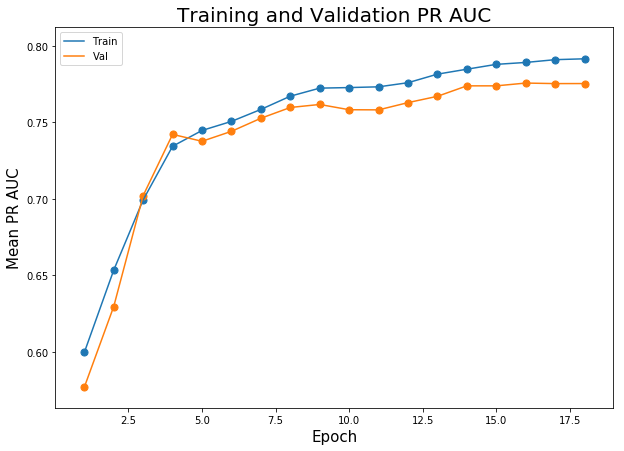

In [22]:
pr_auc_history_train = train_metric_callback.get_pr_auc_history()
pr_auc_history_val = val_callback.get_pr_auc_history()

plt.figure(figsize=(10, 7))
plot_with_dots(plt, pr_auc_history_train[-1])
plot_with_dots(plt, pr_auc_history_val[-1])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean PR AUC', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation PR AUC', fontsize=20)
plt.savefig('pr_auc_hist.png')

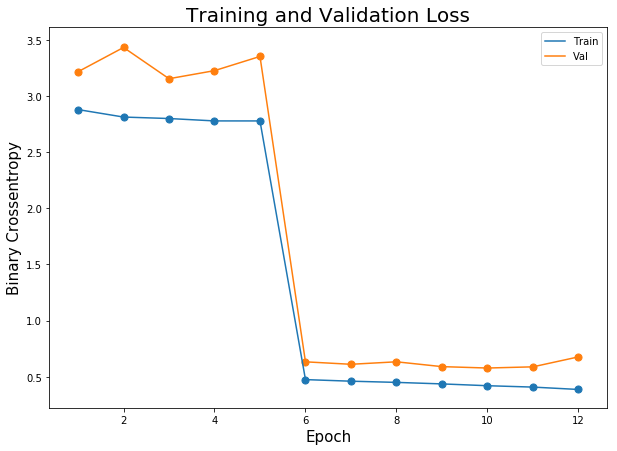

In [58]:
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history_0.history['loss']+history_1.history['loss'])
plot_with_dots(plt, history_0.history['val_loss']+history_1.history['val_loss'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Loss', fontsize=20)
plt.savefig('loss_hist.png')

# Selecting postprocessing thresholds

0.95
0.9999421
0.9148418
0.8312112



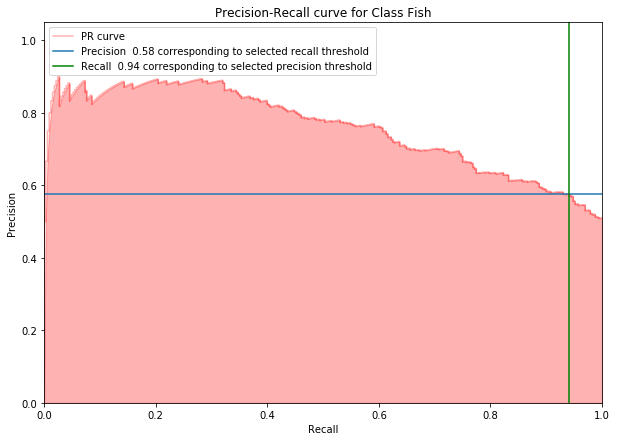

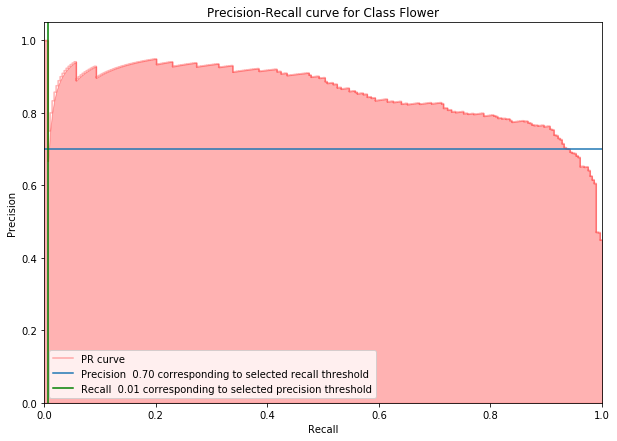

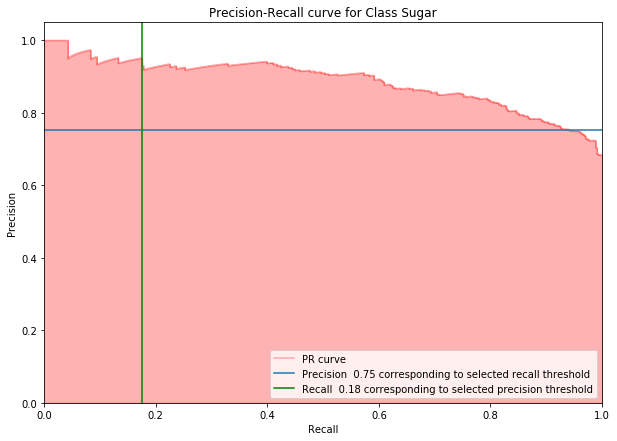

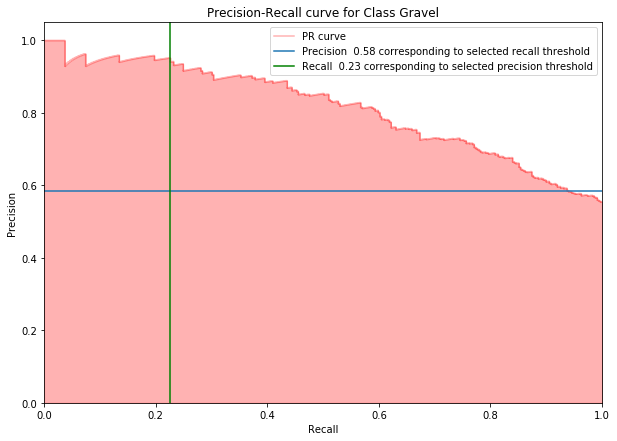

In [43]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.95, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold]
    if not best_precision_threshold:
        best_precision_threshold = 0.95
    else:
        best_precision_threshold = best_precision_threshold[0]
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) if thres == best_precision_threshold]
        if not recall_for_prec_thres:
            recall_for_prec_thres = 0.94
        else:
            recall_for_prec_thres = recall_for_prec_thres[0]
                                                            
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()
precision_thresholds = dict()
for i, class_name in tqdm(enumerate(class_names)):
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, plot=True)

# Post-processing Andrew's submission

Predicting cloud classes for test.

In [44]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

Estimating set of images without masks.

In [45]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

In [46]:
images_labels_full = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] > precision_thresholds[class_name]:
            images_labels_full.add(f'{img}_{class_name}')

My predictions from this kernel : https://www.kaggle.com/mobassir/keras-efficientnetb2-for-classifying-cloud

In [47]:
submission = pd.read_csv('./input/cloudefficientnetb2/submission.csv')
submission.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,5 337 353 343 702 346 1052 347 1401 348 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN


In [48]:
image_labels_andrew_nonempty = submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values
image_labels_andrew_empty = submission.loc[submission['EncodedPixels'].isnull(), 'Image_Label'].values

 I remove the min_size parameter from the post_process function, so that more mask are generated in the submission. I'd add additional masks for the Image_Label pairs predicted by the classifier.

In [51]:
images_to_refill = images_labels_full.intersection(set(image_labels_andrew_empty))
submission_no_minsize = pd.read_csv('./input/clouds-classifier-files/submission_no_minsize.csv')
masks_no_minsize_refillers = submission_no_minsize.loc[submission_no_minsize['Image_Label'].isin(images_to_refill) &
                                                       ~submission_no_minsize['EncodedPixels'].isnull()]
print(f'{len(masks_no_minsize_refillers)} masks would be added.')

15 masks would be added.


In [52]:
print(f'{len(image_labels_empty.intersection(set(image_labels_andrew_nonempty)))} masks would be removed')

84 masks would be removed


In [53]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
# adding masks
img_labels_to_refill = set(masks_no_minsize_refillers['Image_Label'].values)
submission = submission[~submission['Image_Label'].isin(img_labels_to_refill)]
submission = pd.concat((submission, masks_no_minsize_refillers))
submission.to_csv('submission.csv', index=None)

# Future work
1. estimate distribution of classes in test set using the classifier. Then, if necessary and doable, modify val set accordingly,
2. use the classifier with explainability technique [Gradient-weighted Class Activation Mapping](http://gradcam.cloudcv.org/) to generate a baseline,
3. improve the classifier,
4. use the classifier as backbone for UNet-like solution.